**Capstone 2: Modeling**

Problem Statement: The National Transportation Safety Board (NTSB) has an Aviation Accident Database that contains information about civil aviation accidents and incidents that they investigate within the United States, its territories and international waters. For this Project, we will specifically be looking at airplane accidents for the 20 years from 2002 to 2021. The operations included are scheduled Part 121: Air Carrier, which includes most passenger airlines, as well as Part 135: Small Carrier for both commuter and ‘air taxi’ small aircraft. This dataset does not include aircraft accidents where the aircraft involved was amateur built.

**Modeling**

The dataset we're working with is trying to predict which category an accident falls into based on region/location, month, FAR Part number and type of injuries/count. Since we are working with categorical data and I have the labels, I'm going to be using these Supervised Classifcation models to see which one works best:

Random Forest <br> K-Nearest Neighbor <br> Support Vector Machine

**Initial Steps**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = pd.read_excel('data/X_train.xlsx')
X_test = pd.read_excel('data/X_test.xlsx')
y_train = pd.read_excel('data/y_train.xlsx')
y_test = pd.read_excel('data/y_test.xlsx')

**Looking at the difference models compared to each other**

Want to see in general, how these different models are going to compare to each other with this data. This will use the default parameters for each model. Will then go into each model and do train/test. Followed by hyperparameter tuning for the best one or two models.

In [3]:
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

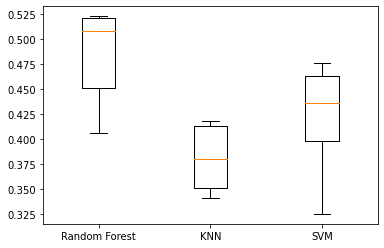

In [4]:
models = {'Random Forest': RandomForestClassifier(), 'KNN': KNeighborsClassifier(), 'SVM': SVC()}
results = []
for model in models.values():
    kf = KFold(n_splits = 6, random_state = 42, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf)
    results.append(cv_results)
    
plt.boxplot(results, labels = models.keys())
plt.show()

None of the models are looking very good based on accuracy, but it looks like RandomForest will end up being the best model. We will need to fine tune these options to see if they improve at all. 

**Class Weights**

We definitely have imbalanced classes, so going to play with class weights in each model that is run.

In [5]:
#class_weights = {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 5}

**Random Forest**

In [6]:
#using random searh first to see what parameters should be around
rf_params = {'criterion': ['gini', 'entropy'], 
                 'class_weight': [{'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 1},
                    {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 5},
                    {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 10},
                    {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 5},
                    {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 10}, 
                    'balanced'],
                 'n_estimators': np.arange(1, 100, step = 5),
                 'max_depth': np.arange(1, 50, step = 5),
                 'min_samples_split': np.arange(2, 20, step = 2),
                 'min_samples_leaf': np.arange(1, 20, step = 2)}
                 
rf_random = RandomizedSearchCV(RandomForestClassifier(max_features = 'sqrt', random_state = 42), rf_params, n_iter = 500, 
                               scoring = 'accuracy', n_jobs = -1, random_state = 123)
rf_random.fit(X_train, y_train.values.ravel())
print(rf_random.best_params_)

{'n_estimators': 21, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_depth': 11, 'criterion': 'gini', 'class_weight': {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ': 1, 'Other': 1}}


In [7]:
#Looking at Accuracy for our final model with parameters from the grid search
rf = RandomForestClassifier(n_estimators = 21, min_samples_split = 4, min_samples_leaf = 9, max_depth = 11,
                            criterion = 'gini', max_features = 'sqrt', random_state = 42,
                            class_weight = {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ': 1, 'Other': 1})
rf.fit(X_train, y_train.values.ravel())
y_pred_rf = rf.predict(X_test)

rf_train_acc = rf.score(X_train, y_train)
rf_test_acc = rf.score(X_test, y_test)

print('Training accuracy:', rf_train_acc, '    Testing accuracy:', rf_test_acc)

Training accuracy: 0.5992217898832685     Testing accuracy: 0.5339366515837104


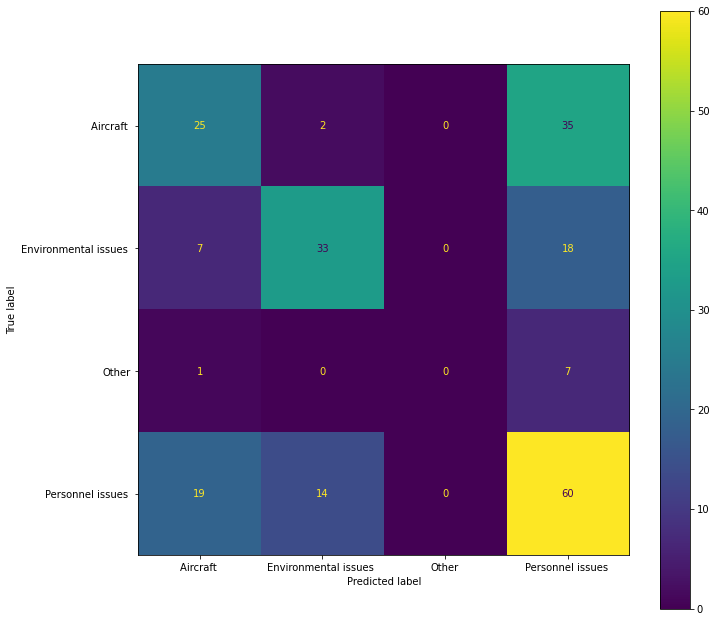

In [8]:
rf_cf_matrix = confusion_matrix(y_test, y_pred_rf)
cmd = ConfusionMatrixDisplay(rf_cf_matrix, display_labels = rf.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [9]:
print(classification_report(y_test, y_pred_rf, target_names = rf.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.48      0.40      0.44        62
Environmental issues        0.67      0.57      0.62        58
                Other       0.00      0.00      0.00         8
    Personnel issues        0.50      0.65      0.56        93

             accuracy                           0.53       221
            macro avg       0.41      0.40      0.40       221
         weighted avg       0.52      0.53      0.52       221



In [10]:
#to use later to compare all the model, I'm going to save the report as a dictionary
rf_report = classification_report(y_test, y_pred_rf, target_names = rf.classes_, zero_division = 0, output_dict = True)

**K-Nearest Neighbor**

In [11]:
#KNN is dependent on how many neighbors you tell it to use. So going to look at that first
neighbors = np.arange(1,20)
train_acc = {}
test_acc = {}

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
    knn.fit(X_train, y_train.values.ravel())
    train_acc[n] = knn.score(X_train, y_train)
    test_acc[n] = knn.score(X_test, y_test)

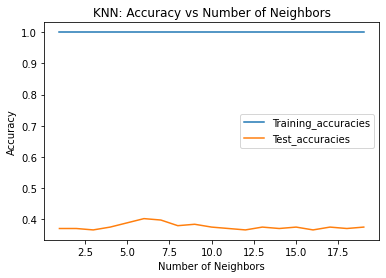

In [12]:
#Plotting the accuracies
plt.title('KNN: Accuracy vs Number of Neighbors')
plt.plot(neighbors, train_acc.values(), label = 'Training_accuracies')
plt.plot(neighbors, test_acc.values(), label = 'Test_accuracies')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [13]:
#Looking at Accuracy for our final model with n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knn.fit(X_train, y_train.values.ravel())
y_pred_knn = knn.predict(X_test)

knn_train_acc = knn.score(X_train, y_train)
knn_test_acc = knn.score(X_test, y_test)

print('Training accuracy:', knn_train_acc, '    Testing accuracy:', knn_test_acc)

Training accuracy: 1.0     Testing accuracy: 0.3891402714932127


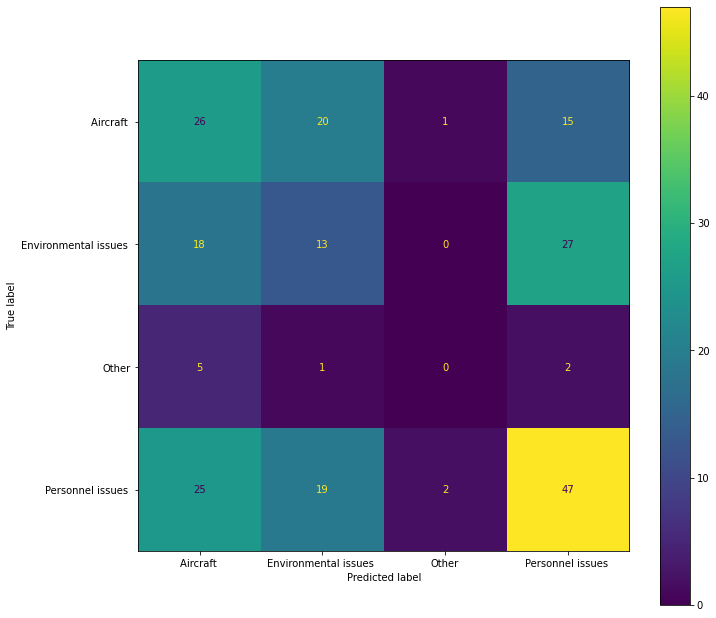

In [14]:
knn_cf_matrix = confusion_matrix(y_test, y_pred_knn)
cmd = ConfusionMatrixDisplay(knn_cf_matrix, display_labels = knn.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [15]:
print(classification_report(y_test, y_pred_knn, target_names = knn.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.35      0.42      0.38        62
Environmental issues        0.25      0.22      0.23        58
                Other       0.00      0.00      0.00         8
    Personnel issues        0.52      0.51      0.51        93

             accuracy                           0.39       221
            macro avg       0.28      0.29      0.28       221
         weighted avg       0.38      0.39      0.38       221



In [16]:
knn_report = classification_report(y_test, y_pred_knn, target_names = knn.classes_, zero_division = 0, output_dict = True)

**Support Vector Machine**

In [17]:
# defining parameter range
svm_params = {'C': [0.1, 1, 10, 100, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'class_weight': [{'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 1},
                             {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 5},
                             {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 10},
                             {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 5},
                             {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 10},
                             'balanced']}
  
svm_grid = GridSearchCV(SVC(), svm_params)
svm_grid.fit(X_train, y_train.values.ravel())
print(svm_grid.best_params_)

{'C': 1, 'class_weight': {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ': 1, 'Other': 1}, 'gamma': 0.01}


In [18]:
#Looking at Accuracy for our final model with C = 1 and gamma = 0.01
svm = SVC(C = 1, gamma = .01, class_weight = {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 1})
svm.fit(X_train, y_train.values.ravel())
y_pred_svm = svm.predict(X_test)

svm_train_acc = svm.score(X_train, y_train)
svm_test_acc = svm.score(X_test, y_test)

print('Training accuracy:', svm_train_acc, '    Testing accuracy:', svm_test_acc)

Training accuracy: 0.9494163424124513     Testing accuracy: 0.4072398190045249


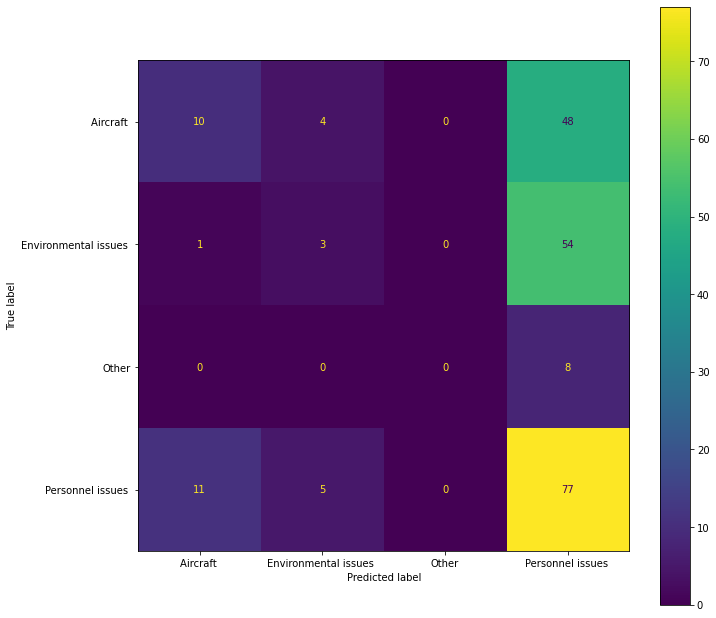

In [19]:
svm_cf_matrix = confusion_matrix(y_test, y_pred_svm)
cmd = ConfusionMatrixDisplay(svm_cf_matrix, display_labels = svm.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [20]:
print(classification_report(y_test, y_pred_svm, target_names = svm.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.45      0.16      0.24        62
Environmental issues        0.25      0.05      0.09        58
                Other       0.00      0.00      0.00         8
    Personnel issues        0.41      0.83      0.55        93

             accuracy                           0.41       221
            macro avg       0.28      0.26      0.22       221
         weighted avg       0.37      0.41      0.32       221



In [21]:
svm_report = classification_report(y_test, y_pred_svm, target_names = svm.classes_, zero_division = 0, output_dict = True)

**Oversampling**

We've definitely have an imbalanced dataset, which class weights don't seem to help very much. So I'm going to try oversampling using SMOTE.

In [22]:
y_train.value_counts()

Failure_Category     
Personnel issues         217
Aircraft                 150
Environmental issues     134
Other                     13
dtype: int64

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
classes = {'Environmental issues ': 150, 'Other': 150}
smote = SMOTE(sampling_strategy = classes, random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [25]:
y_train_smote.value_counts()

Failure_Category     
Personnel issues         217
Aircraft                 150
Environmental issues     150
Other                    150
dtype: int64

Now going to try running the three models again with the oversampled data.

**Over Sampled Random Forest**

In [26]:
rf_params_smote = {'criterion': ['gini', 'entropy'], 
                   'class_weight': [{'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 1},
                    {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 5},
                    {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 10},
                    {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 5},
                    {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 10}, 
                    'balanced'],
                   'n_estimators': np.arange(1, 100, step = 5),
                   'max_depth': np.arange(1, 50, step = 5),
                   'min_samples_split': np.arange(2, 20, step = 2),
                   'min_samples_leaf': np.arange(1, 20, step = 2)}
                 
rf_random_smote = RandomizedSearchCV(RandomForestClassifier(max_features = 'sqrt', random_state = 42), rf_params_smote, 
                                     n_iter = 500, scoring = 'accuracy', n_jobs = -1, random_state = 123)
rf_random_smote.fit(X_train_smote, y_train_smote.values.ravel())
print(rf_random_smote.best_params_)

{'n_estimators': 41, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 41, 'criterion': 'entropy', 'class_weight': 'balanced'}


In [27]:
#Looking at Accuracy for our final model with parameters from the grid search
rf_smote = RandomForestClassifier(n_estimators = 41, min_samples_split = 10, min_samples_leaf = 1, max_depth = 41,
                                  criterion = 'entropy', max_features = 'sqrt',  random_state = 42,
                                  class_weight = 'balanced')
rf_smote.fit(X_train_smote, y_train_smote.values.ravel())
y_pred_rf_smote = rf_smote.predict(X_test)

rf_smote_train_acc = rf_smote.score(X_train_smote, y_train_smote)
rf_smote_test_acc = rf_smote.score(X_test, y_test)

print('Training accuracy:', rf_smote_train_acc, '    Testing accuracy:', rf_smote_test_acc)

Training accuracy: 0.8365817091454273     Testing accuracy: 0.5429864253393665


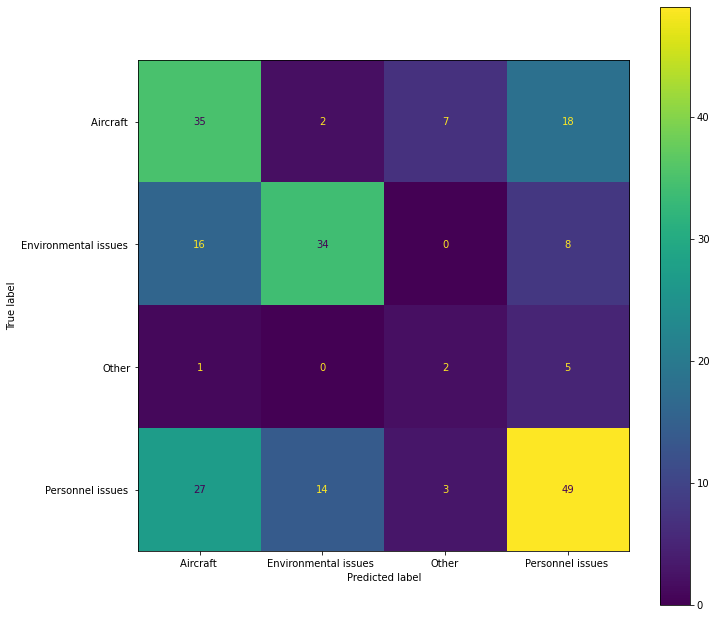

In [28]:
rf_smote_cf_matrix = confusion_matrix(y_test, y_pred_rf_smote)
cmd = ConfusionMatrixDisplay(rf_smote_cf_matrix, display_labels = rf_smote.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [29]:
print(classification_report(y_test, y_pred_rf_smote, target_names = rf_smote.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.44      0.56      0.50        62
Environmental issues        0.68      0.59      0.63        58
                Other       0.17      0.25      0.20         8
    Personnel issues        0.61      0.53      0.57        93

             accuracy                           0.54       221
            macro avg       0.48      0.48      0.47       221
         weighted avg       0.57      0.54      0.55       221



In [30]:
rf_smote_report = classification_report(y_test, y_pred_rf_smote, target_names = rf_smote.classes_, zero_division = 0, output_dict = True)

**Over Sampled K Nearest**

In [31]:
#KNN is dependent on how many neighbors you tell it to use. So going to look at that first
neighbors = np.arange(1,20)
train_acc_s = {}
test_acc_s = {}

for n in neighbors:
    knn_smote = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
    knn_smote.fit(X_train_smote, y_train_smote.values.ravel())
    train_acc_s[n] = knn_smote.score(X_train_smote, y_train_smote)
    test_acc_s[n] = knn_smote.score(X_test, y_test)

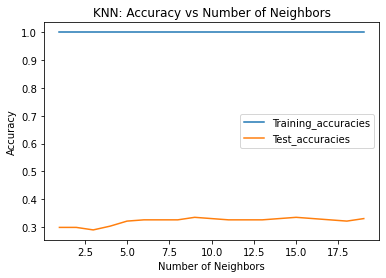

In [32]:
#Plotting the accuracies
plt.title('KNN: Accuracy vs Number of Neighbors')
plt.plot(neighbors, train_acc_s.values(), label = 'Training_accuracies')
plt.plot(neighbors, test_acc_s.values(), label = 'Test_accuracies')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [33]:
#Looking at Accuracy for our final model with n_neighbors = 9
knn_smote = KNeighborsClassifier(n_neighbors = 9)
knn_smote.fit(X_train_smote, y_train_smote.values.ravel())
y_pred_knn_smote = knn_smote.predict(X_test)

knn_smote_train_acc = knn_smote.score(X_train_smote, y_train_smote)
knn_smote_test_acc = knn_smote.score(X_test, y_test)

print('Training accuracy:', knn_smote_train_acc, '    Testing accuracy:', knn_smote_test_acc)

Training accuracy: 0.5367316341829086     Testing accuracy: 0.3212669683257919


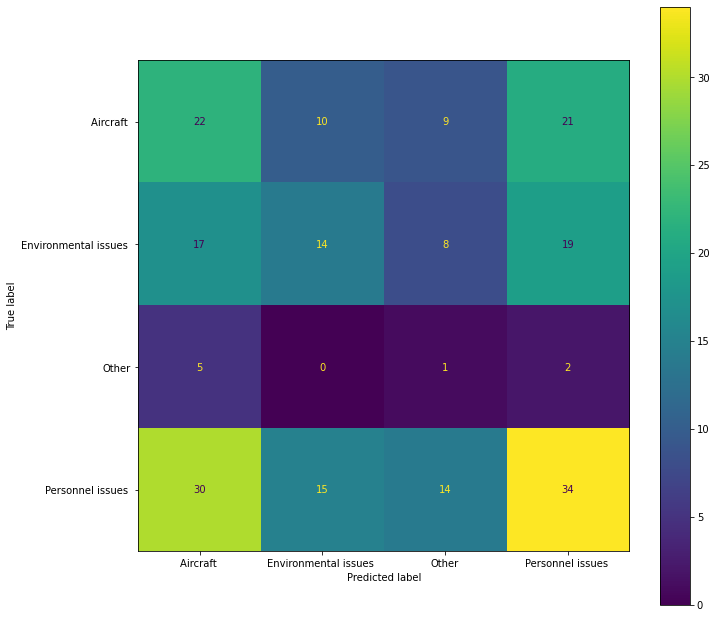

In [34]:
knn_smote_cf_matrix = confusion_matrix(y_test, y_pred_knn_smote)
cmd = ConfusionMatrixDisplay(knn_smote_cf_matrix, display_labels = knn_smote.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [35]:
print(classification_report(y_test, y_pred_knn_smote, target_names = knn_smote.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.30      0.35      0.32        62
Environmental issues        0.36      0.24      0.29        58
                Other       0.03      0.12      0.05         8
    Personnel issues        0.45      0.37      0.40        93

             accuracy                           0.32       221
            macro avg       0.28      0.27      0.27       221
         weighted avg       0.37      0.32      0.34       221



In [36]:
knn_smote_report = classification_report(y_test, y_pred_knn_smote, target_names = knn_smote.classes_, zero_division = 0, output_dict = True)

**Over Sampled SVM**

In [37]:
# defining parameter range
svm_smote_params = {'C': [0.1, 1, 10, 100, 1000], 
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                    'class_weight': [{'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 1},
                        {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 5},
                        {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 10},
                        {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 2},
                        {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 5},
                        'balanced']}
  
svm_smote_grid = GridSearchCV(SVC(), svm_smote_params)
svm_smote_grid.fit(X_train_smote, y_train_smote.values.ravel())
print(svm_smote_grid.best_params_)

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.01}


In [38]:
#Looking at Accuracy for our final model with C = 1 and gamma = 0.01
svm_smote = SVC(C = 1, gamma = .01, class_weight = 'balanced')
svm_smote.fit(X_train_smote, y_train_smote.values.ravel())
y_pred_svm_smote = svm_smote.predict(X_test)

svm_smote_train_acc = svm_smote.score(X_train_smote, y_train_smote)
svm_smote_test_acc = svm_smote.score(X_test, y_test)

print('Training accuracy:', svm_smote_train_acc, '    Testing accuracy:', svm_smote_test_acc)

Training accuracy: 0.974512743628186     Testing accuracy: 0.36199095022624433


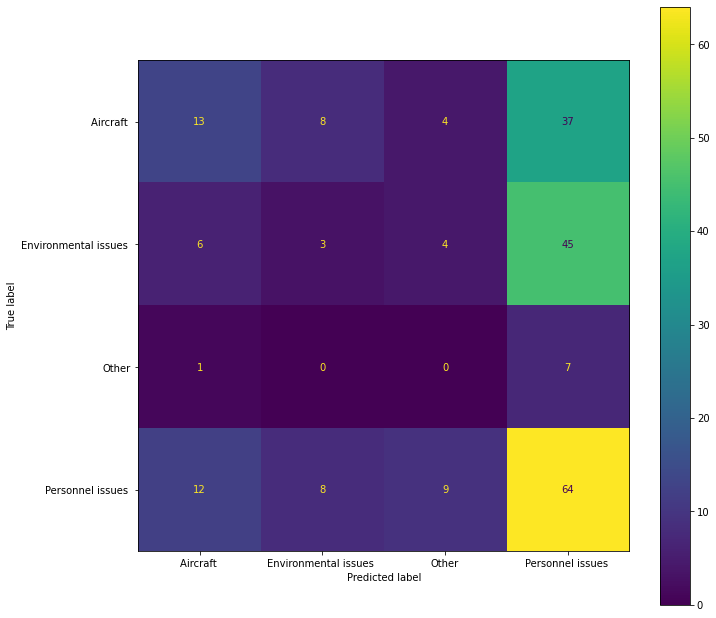

In [39]:
svm_smote_cf_matrix = confusion_matrix(y_test, y_pred_svm_smote)
cmd = ConfusionMatrixDisplay(svm_smote_cf_matrix, display_labels = svm_smote.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [40]:
print(classification_report(y_test, y_pred_svm_smote, target_names = svm_smote.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.41      0.21      0.28        62
Environmental issues        0.16      0.05      0.08        58
                Other       0.00      0.00      0.00         8
    Personnel issues        0.42      0.69      0.52        93

             accuracy                           0.36       221
            macro avg       0.25      0.24      0.22       221
         weighted avg       0.33      0.36      0.32       221



In [41]:
svm_smote_report = classification_report(y_test, y_pred_svm_smote, target_names = svm_smote.classes_, zero_division = 0, output_dict = True)

**Comparing Models**

Want to compare the model's training accuracy, testing accuracy and weighted averages for precision, recall and f1-score.

In [42]:
model_data = {'Model': ['RF', 'KNN', 'SVM', 'Oversampled RF', 'Oversampled KNN', 'Oversampled SVM'],
             'Training Acc': [rf_train_acc, knn_train_acc, svm_train_acc, rf_smote_train_acc, knn_smote_train_acc, svm_smote_train_acc],
             'Testing Acc': [rf_test_acc, knn_test_acc, svm_test_acc, rf_smote_test_acc, knn_smote_test_acc, svm_smote_test_acc],
             'Precision': [rf_report['weighted avg']['precision'], knn_report['weighted avg']['precision'], svm_report['weighted avg']['precision'],
                          rf_smote_report['weighted avg']['precision'], knn_smote_report['weighted avg']['precision'], svm_smote_report['weighted avg']['precision']],
             'Recall': [rf_report['weighted avg']['recall'], knn_report['weighted avg']['recall'], svm_report['weighted avg']['recall'],
                       rf_smote_report['weighted avg']['recall'], knn_smote_report['weighted avg']['recall'], svm_smote_report['weighted avg']['recall']],
             'f1-score': [rf_report['weighted avg']['f1-score'], knn_report['weighted avg']['f1-score'], svm_report['weighted avg']['f1-score'],
                         rf_smote_report['weighted avg']['f1-score'], knn_smote_report['weighted avg']['f1-score'], svm_smote_report['weighted avg']['f1-score']]}

#making a dataframe
results = pd.DataFrame(model_data)
results

,Model,Training Acc,Testing Acc,Precision,Recall,f1-score
0,RF,0.599222,0.533937,0.522031,0.533937,0.522005
1,KNN,1.000000,0.389140,0.380286,0.389140,0.383721
2,SVM,0.949416,0.407240,0.366407,0.407240,0.320739
3,Oversampled RF,0.836582,0.542986,0.566535,0.542986,0.550139
4,Oversampled KNN,0.536732,0.321267,0.367005,0.321267,0.337653
5,Oversampled SVM,0.974513,0.361991,0.331436,0.361991,0.317008


Overall, the Random Forest Model trained with the SMOTE oversampled data gives the best performance of the three models tried. Oversampling the data marginally helped the random forest model, but actually decreased the performance in the KNN and SVM models.

The Random Forest Model that worked best used the following paramters: criterion = 'entropy', n_estimators = 41, min_samples_split = 10, min_samples_leaf = 1, max_depth = 41, max_features = 'sqrt', class_weight = 'balanced'.